# Extended Figure 16

In [355]:
import scanpy as sc
import pandas as pd
import numpy as np
import anndata as ad

import mplscience
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import sparse
from sklearn.utils import check_random_state
from sklearn.metrics import pairwise_distances
from mousipy import translate

import os
import warnings
warnings.filterwarnings('ignore')

data_path = '../public/'
marker_path = '../markers/'
plot_path = '../plot/'
output_path = '../output/'
pb_path = '../output/pseudobulk/'
tr_path = '../output/translated/'

seed = 777

- code from : https://www.sc-best-practices.org/conditions/gsea_pathway.html

In [64]:
def subsampled_summation(adata, groupby, keep,  *, n_samples_per_group = 3, n_cells = 50, random_state=777, layer: str = None):
    random_state = check_random_state(random_state)
    indices = []
    labels = []

    grouped = adata.obs.groupby(groupby)
    for k, inds in grouped.indices.items():
        if len(inds) < (n_cells * n_samples_per_group):
            continue

        condition_inds = random_state.choice(
            inds, n_cells * n_samples_per_group, replace=False
        )
        for i, sample_condition_inds in enumerate(np.split(condition_inds, n_samples_per_group)):
            if isinstance(k, tuple):
                labels.append((*k, i))
            else:  
                labels.append((k, i))
            indices.append(sample_condition_inds)

    new_obs = pd.DataFrame.from_records(
        labels,
        columns=[*groupby, "sample"],
        index=["-".join(map(str, l)) for l in labels],
    )
    n_out = len(labels)

    indptr = np.arange(0, (n_out + 1) * n_cells, n_cells)
    indicator = sparse.csr_matrix(
        (
            np.ones(n_out * n_cells, dtype=bool),
            np.concatenate(indices),
            indptr,
        ),
        shape=(len(labels), adata.n_obs),
    )

    
    new_adata = ad.AnnData(
        X=indicator @ sc.get._get_obs_rep(adata, layer=layer),
        obs=new_obs,
        var=adata.var.copy(),
    )
    del new_adata.var

    if isinstance(keep, str):
        keep = [keep]
    for k in keep:
        new_adata.obs[k] = [adata.obs[k].iloc[inds].mode().iloc[0] for inds in indices]

    return new_adata

# 1. Create pseudobulk data and save

- astrocytoma

In [65]:
astrocytoma = sc.read_h5ad(os.path.join(data_path, 'human_astrocytoma.h5ad'))
astrocytoma = astrocytoma.raw.to_adata()
adata = translate(astrocytoma)
adata = adata[:,~adata.var['original_gene_symbol'].isna()]
adata.layers['counts'] = adata.X.copy()
subset = adata[adata.obs['New_NMF_labelling'].isin(['Astro-like', 'Cycling-like', 'Gradient', 'Mixed', 'OPC-like', 'RA'])].copy()

AnnData object with n_obs × n_vars = 72385 × 3000
    obs: 'nCount_RNA', 'nFeature_RNA', 'percent.mt', 'orig.ident', 'seurat_clusters', 'grade', 'New_NMF_labelling'
    var: 'sct.detection_rate', 'sct.gmean', 'sct.variance', 'sct.residual_mean', 'sct.residual_variance', 'sct.variable'
    uns: 'neighbors'
    obsm: 'X_harmony', 'X_pca', 'X_tsne', 'X_umap'
    varm: 'HARMONY', 'PCs'
    layers: 'scaled'
    obsp: 'distances'

In [219]:
# subset.write(os.path.join(tr_path, 'astrocytoma.h5ad'))
# subset = sc.read_h5ad(os.path.join(tr_path, 'astrocytoma.h5ad'))

In [220]:
sc.pp.filter_genes(subset, int(subset.shape[0] * 0.1))
sc.pp.normalize_total(subset)
sc.pp.log1p(subset)
sc.pp.highly_variable_genes(subset, n_top_genes=5000, batch_key='orig.ident', subset=True)

In [221]:
pb_a = subsampled_summation(subset, ['orig.ident'], keep=["New_NMF_labelling"], n_samples_per_group=2, n_cells=100, random_state=seed, layer='counts')
pb_a

AnnData object with n_obs × n_vars = 12 × 5000
    obs: 'orig.ident', 'sample', 'New_NMF_labelling'

In [222]:
pb_a.write(os.path.join(pb_path, 'astrocytoma.h5ad'))

- oligodendroglioma

In [84]:
oligodendroma = sc.read_h5ad(os.path.join(data_path, 'human_oligodendroma.h5ad'))
oligodendroma = oligodendroma.raw.to_adata()
adata = translate(oligodendroma)
adata = adata[:,~adata.var['original_gene_symbol'].isna()]
adata.layers['counts'] = adata.X.copy()
subset = adata[adata.obs['New_NMF_labelling'].isin(['Astro-like', 'Cycling-like', 'Gradient', 'Mixed', 'OPC-like', 'RA'])].copy()

100%|██████████| 27584/27584 [00:41<00:00, 670.45it/s]


Found direct orthologs for 15199 genes.
Found multiple orthologs for 432 genes.
Found no orthologs for 3743 genes.
Found no index in biomart for 8210 genes.


100%|██████████| 432/432 [00:22<00:00, 19.41it/s]


In [223]:
# subset.write(os.path.join(tr_path, 'oligodendroglioma.h5ad'))
# subset = sc.read_h5ad(os.path.join(tr_path, 'oligodendroglioma.h5ad'))

In [224]:
sc.pp.filter_genes(subset, int(subset.shape[0] * 0.1))
sc.pp.normalize_total(subset)
sc.pp.log1p(subset)
sc.pp.highly_variable_genes(subset, n_top_genes=5000, batch_key='orig.ident', subset=True)

In [225]:
pb_o = subsampled_summation(subset, ['orig.ident'], keep=["New_NMF_labelling"], n_samples_per_group=2, n_cells=100, random_state=seed, layer='counts')
pb_o

AnnData object with n_obs × n_vars = 16 × 5000
    obs: 'orig.ident', 'sample', 'New_NMF_labelling'

In [226]:
pb_o.write(os.path.join(pb_path, 'oligodendroma.h5ad'))

- gbm

In [122]:
gbm = sc.read_h5ad(os.path.join(output_path, 'coreGBmap_homologue.h5ad'))
cellid = pd.read_csv(os.path.join(output_path, 'CellID.csv'), index_col=0)
gbm.obs['cell_type'] = cellid.loc[gbm.obs_names, 'CellID']
subset = gbm[gbm.obs['cell_type'].isin(['MES-like',
 'OPC-like',
 'AC-like',
 'NPC-like',
])].copy()

In [227]:
# subset.write(os.path.join(tr_path, 'glioblastoma.h5ad'))
# subset = sc.read_h5ad(os.path.join(tr_path, 'glioblastoma.h5ad'))

In [228]:
sc.pp.filter_genes(subset, int(subset.shape[0] * 0.1))
sc.pp.normalize_total(subset)
sc.pp.log1p(subset)
sc.pp.highly_variable_genes(subset, n_top_genes=5000, batch_key = 'author', subset=True)

In [229]:
pb_g = subsampled_summation(subset, ['author'], keep=["cell_type"], n_samples_per_group=1, n_cells=100, random_state=seed, layer='counts')
pb_g

AnnData object with n_obs × n_vars = 13 × 5000
    obs: 'author', 'sample', 'cell_type'

In [230]:
pb_g.write(os.path.join(pb_path, 'gbm.h5ad'))

- mouse

In [231]:
adata = sc.read_h5ad(os.path.join(output_path, 'annotated_hvg.h5ad'))
adata = adata.raw.to_adata()
adata.layers['counts'] = adata.X.copy()
subset = adata[adata.obs.cell_type == "Tumor"].copy()

In [232]:
sc.pp.filter_genes(subset, int(subset.shape[0] * 0.1))
sc.pp.normalize_total(subset)
sc.pp.log1p(subset)
sc.pp.highly_variable_genes(subset, n_top_genes=5000, batch_key = 'sample_id', subset=True)

In [233]:
pb_m = subsampled_summation(subset, ['sample_id'], keep = 'cell_type', n_samples_per_group=3, n_cells = 100, random_state=seed, layer='counts')
pb_m

AnnData object with n_obs × n_vars = 9 × 5000
    obs: 'sample_id', 'sample', 'cell_type'

In [234]:
pb_m.write(os.path.join(pb_path, 'mouse.h5ad'))

# 2. Load data

In [386]:
adatas = []
for f in os.listdir(pb_path):
    adata = sc.read_h5ad(os.path.join(pb_path, f))
    adata.obs['tumor_type'] = f.split('.')[0]
    if not 'cell_type' in adata.obs.columns:
        adata.obs['cell_type'] = adata.obs['New_NMF_labelling']
    adatas.append(adata)

In [387]:
adatas

[AnnData object with n_obs × n_vars = 13 × 5000
     obs: 'author', 'sample', 'cell_type', 'tumor_type',
 AnnData object with n_obs × n_vars = 12 × 5000
     obs: 'orig.ident', 'sample', 'New_NMF_labelling', 'tumor_type', 'cell_type',
 AnnData object with n_obs × n_vars = 9 × 5000
     obs: 'sample_id', 'sample', 'cell_type', 'tumor_type',
 AnnData object with n_obs × n_vars = 16 × 5000
     obs: 'orig.ident', 'sample', 'New_NMF_labelling', 'tumor_type', 'cell_type']

In [388]:
# gbm, astrocytoma, mouse, oligodendroma
adatas[0].obs['type'] = [f'Glioblastoma{i}' for i in range(1, len(adatas[0])+1)]
adatas[1].obs['type'] = [f'Astrocytoma{i}' for i in range(1, len(adatas[1])+1)]
adatas[2].obs['type'] = [f'Mouse Model{i}' for i in range(1, len(adatas[2])+1)]
adatas[3].obs['type'] = [f'Oligodendroglioma{i}' for i in range(1, len(adatas[3])+1)]

In [389]:
adata = sc.concat(adatas)
adata

AnnData object with n_obs × n_vars = 50 × 1184
    obs: 'sample', 'cell_type', 'tumor_type', 'type'

In [375]:
sc.pp.normalize_total(adata)
sc.pp.log1p(adata)

In [376]:
dist_matrix = pd.DataFrame(pairwise_distances(adata.X.toarray(), metric="correlation"), index = adata.obs.type, columns = adata.obs.type)
corr_mtx = 1 - dist_matrix 

1 extra bytes in post.stringData array
'created' timestamp seems very low; regarding as unix timestamp
Zapf NOT subset; don't know how to subset; dropped
feat NOT subset; don't know how to subset; dropped
morx NOT subset; don't know how to subset; dropped


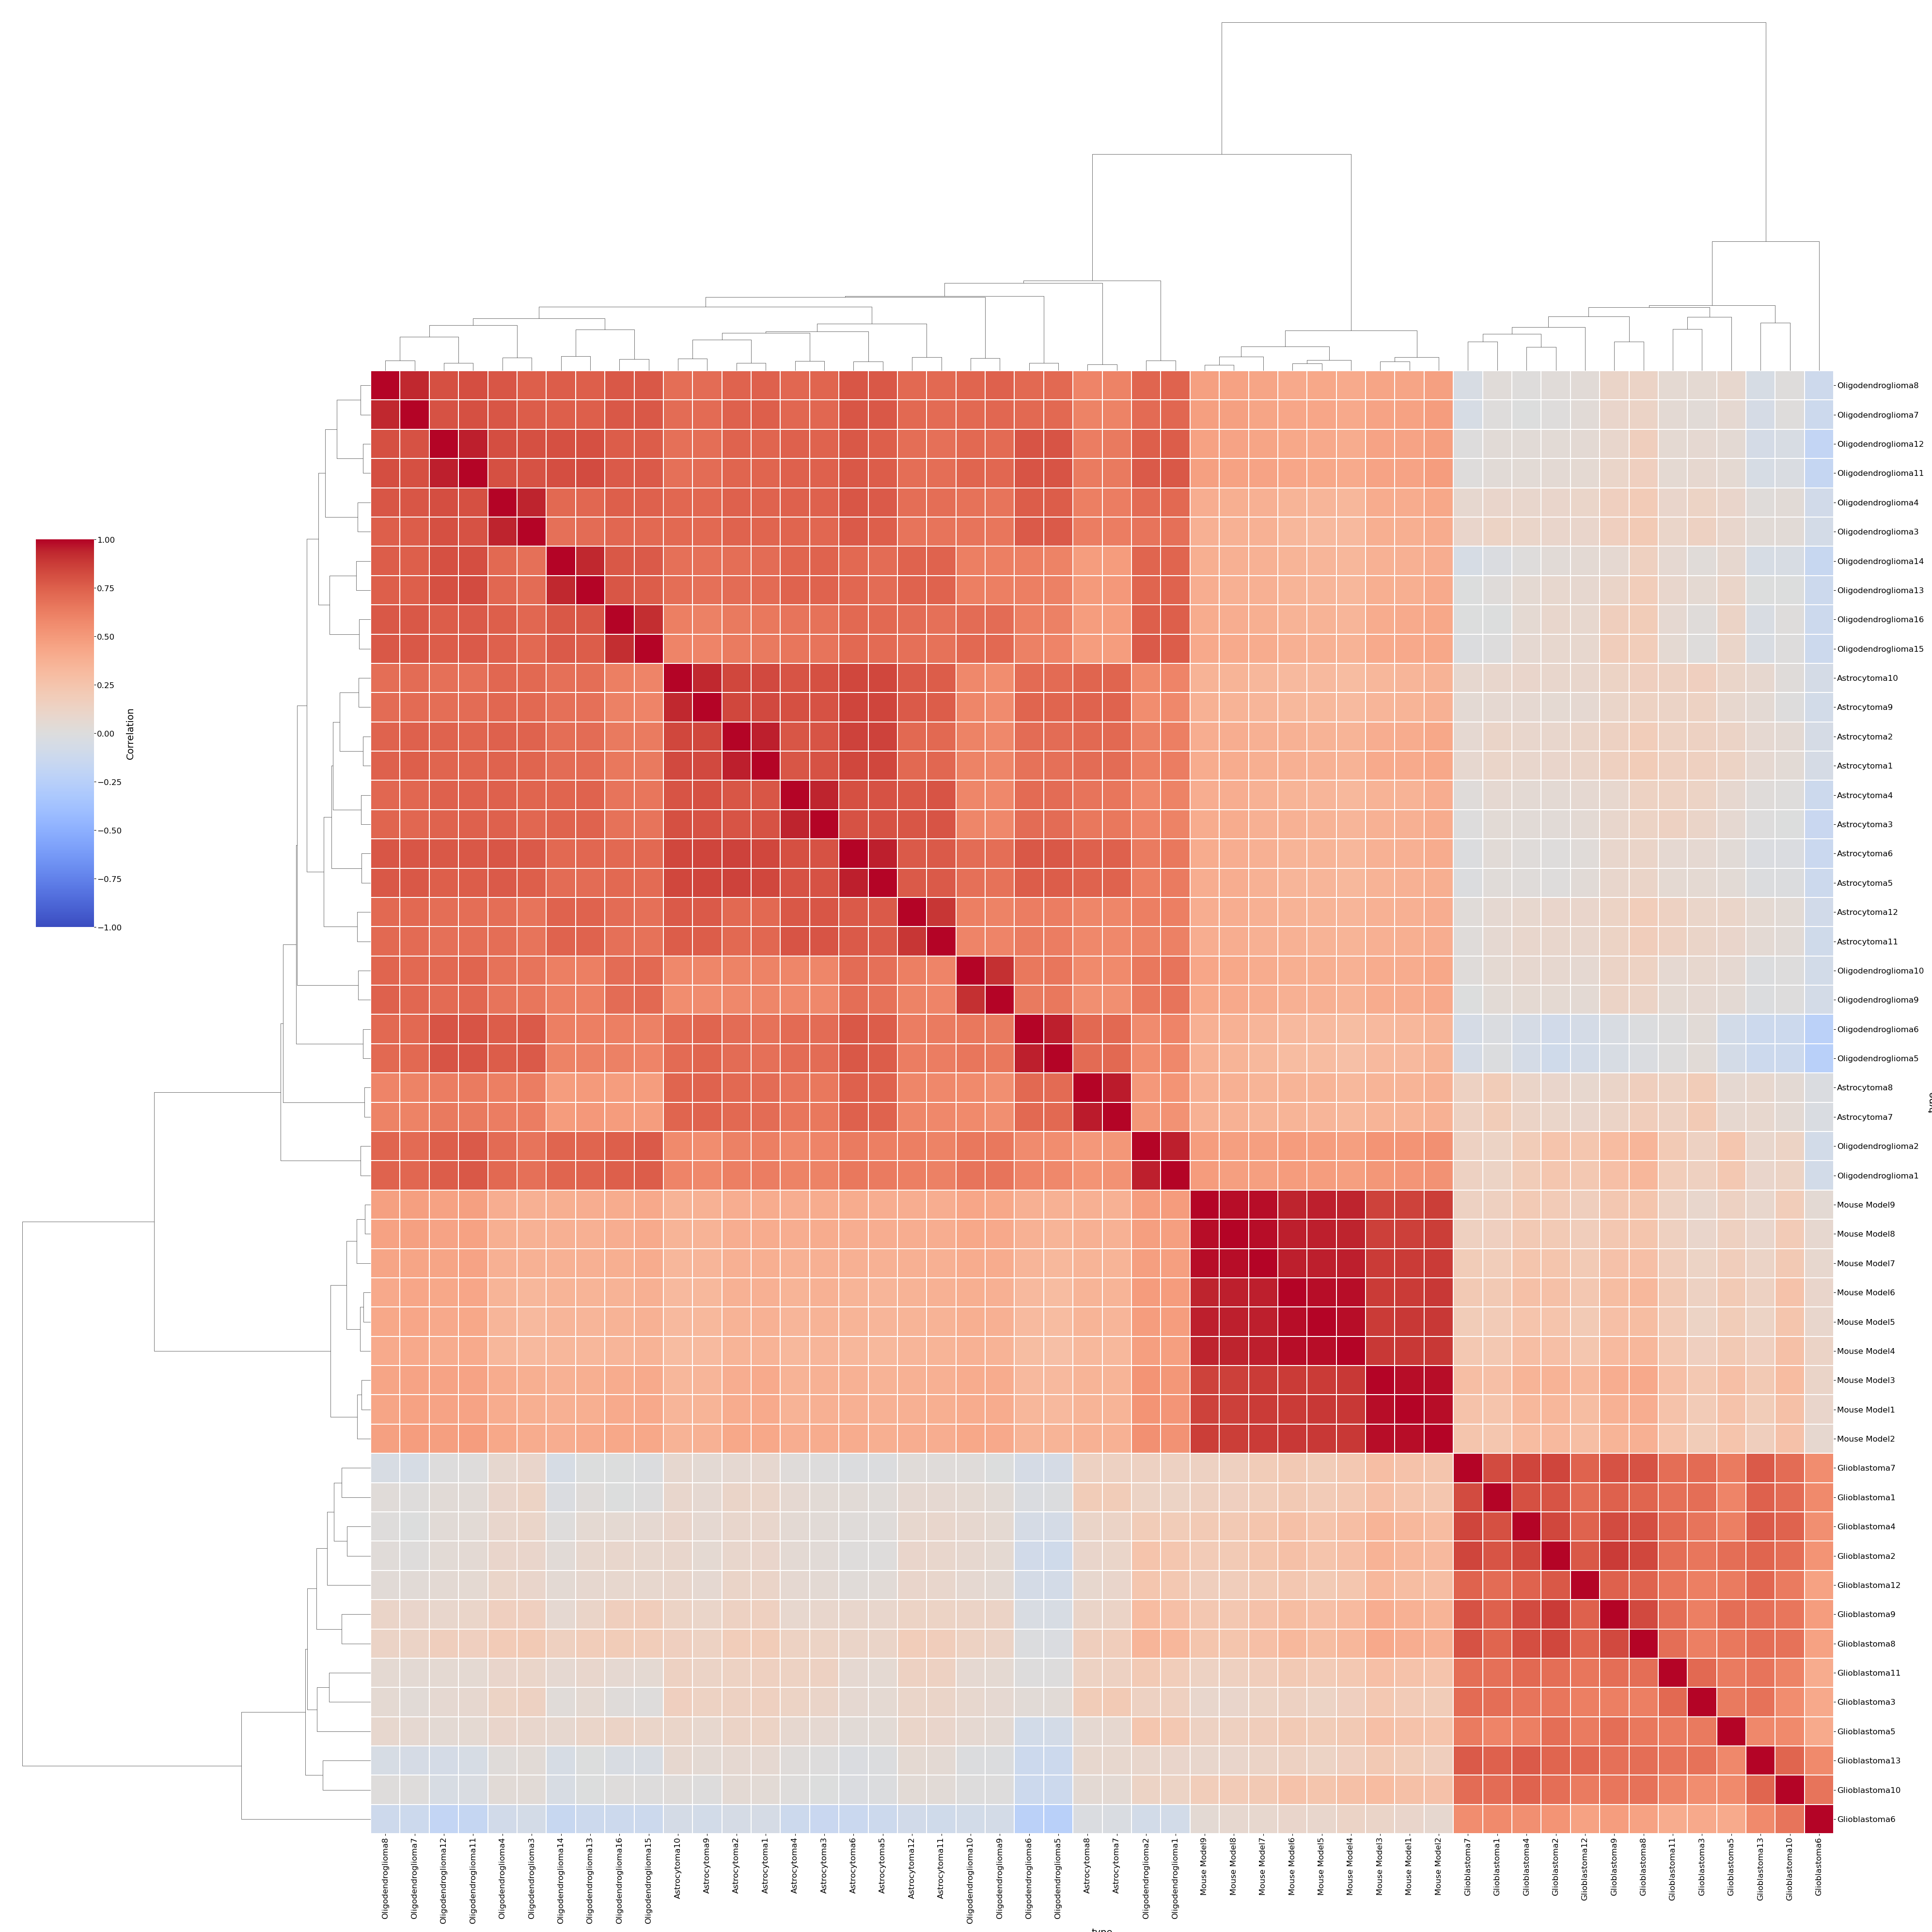

In [412]:
with mplscience.style_context():
    g = sns.clustermap(corr_mtx,
                       cmap='coolwarm', 
                       figsize=(40,40),
                       center=0,  
                       vmin=-1, vmax=1,  
                       cbar_pos=(0.02, 0.52, .03, .2),  
                       cbar_kws={'label': 'Correlation'},
                       linewidths=0.01,
                       )
    
    clustered_data = g.data2d
    flipped_data = clustered_data.T.iloc[::-1, ::-1]
    
    g.ax_heatmap.collections[0].set_array(flipped_data.values.ravel())
    
    g.ax_heatmap.set_yticklabels(g.ax_heatmap.get_yticklabels()[::-1])
    g.ax_heatmap.set_xticklabels(g.ax_heatmap.get_xticklabels()[::-1])
    
    g.ax_row_dendrogram.invert_yaxis()
    g.ax_col_dendrogram.invert_xaxis()
    
    plt.savefig(os.path.join(plot_path, 'Fig4X_correlation_matrix.pdf'), dpi=300, bbox_inches='tight')